# Практическое задание. Градиентный бустинг

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, так что заодно научимся, как его правильно готовить

In [2]:
from collections import defaultdict
from warnings import filterwarnings
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

sns.set(style='darkgrid')
filterwarnings('ignore')

In [3]:
X = load_npz('data/x.npz')
y = np.load('data/y.npy')

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

print(X_train.shape, X_valid.shape, X_test.shape)

(6400, 200) (800, 200) (800, 200)


---

## Задание 1. Базовый градиентный бустинг

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. В заданиях есть референсы для параметров, которые нужно сделать, на случай, если объяснение из ноутбука непонятно, тогда советуем обратиться к соответствующей документации

Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Обязательные параметры:
 — `base_model_class` — класс базовой модели нашего бустинга
 — `base_model_params` — словарь с гиперпараметрами для базовой модели
 — `n_estimators` — какое количество базовых моделей нужно обучить
 — `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$

#### Описание методов

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

После всего цикла обучения надо нарисовать график (если `plot=True`).

В `partial_fit` приходит обучающая выборка, на которую обучается новая базовая модель

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

В `plot_history` приходит любая выборка, для которой последовательно считаются значения функции потерь и/или любой метрики, которую вы хотите посчитать, путем последовательного применения базовых моделей. Можно делать сразу во время обучения, можно делать иначе

### Реализация

In [ ]:
def score(clf, x, y):
    '''метод возвращает рок аук'''
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1]) 


class Boosting:
    def __init__(
        self,
        base_model_class = DecisionTreeRegressor, #выбранная модель
        base_model_params: Optional[dict] = None, # паредаваемы переметры
        n_estimators: int = 10, #число итераций бустинга - число моделей
        learning_rate: float = 0.1, # шаг обучения градиентного алгоритма
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = [] #храним все модели
        self.gammas: list = [] # список гамм - параметр влияния каждого алгоритма в ансабле

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}
        # история изменения рок аук и лосса для проверки далее растет или падает


        self.sigmoid = lambda x: 1 / (1 + np.exp(-x)) # сигмоидная функция для подсчета вероятностей

        #функция потерь - возвращает скаляр - среднее значение лосса на ткущий момент
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean() 

        # проиводная лосса
        self.loss_derivative = lambda y, z: - y * self.sigmoid(-y * z)


    #вспомогательный метод который обучает +1 дерево в ансабле
    def partial_fit(self, X, y):
        n = X.shape[0]

        # z_old: текущие скоры ансамбля на X (сумма прошлых деревьев)
        old_predictions = np.zeros(n)
        for model, gamma in zip(self.models, self.gammas):
            old_predictions += self.learning_rate * gamma * model.predict(X)

        # r: антиградиент loss по z (цель для нового дерева)
        resid = -self.loss_derivative(y, old_predictions)

        # обучаем новое дерево предсказывать r(x)
        model = self.base_model_class(**self.base_model_params)
        model.fit(X, resid)

        # b(x): предсказания нового дерева на X
        new_predictions = model.predict(X)

        # gamma: подбираем оптимальный шаг для добавления дерева (минимизируем loss)
        gamma = self.find_optimal_gamma(y, old_predictions, new_predictions)

        # сохраняем дерево и его коэффициент
        self.models.append(model)
        self.gammas.append(gamma)

        return self

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        for _ in range(self.n_estimators):
            # добавляем 1 новое дерево в ансамбль
            self.partial_fit(X_train, y_train)

            # z_train: текущие скоры ансамбля на train (сумма всех деревьев)
            z_train = np.zeros(y_train.shape[0])
            for model, gamma in zip(self.models, self.gammas):
                z_train += self.learning_rate * gamma * model.predict(X_train)

            # логируем качество на train
            self.history["train_loss"].append(float(self.loss_fn(y_train, z_train)))
            self.history["train_roc_auc"].append(float(self.score(X_train, y_train)))

        # рисуем графики истории обучения
        if plot:
            self.plot_history(X_train, y_train)

        return self


    def predict_proba(self, X):
        # z: скоры ансамбля на X (сумма деревьев)
        curr_score = np.zeros(X.shape[0])
        for model, gamma in zip(self.models, self.gammas):
            curr_score += self.learning_rate * gamma * model.predict(X)

        # переводим скор в вероятности класса +1 и -1
        probas_plus = self.sigmoid(curr_score)      # P(y=+1 | x)
        probas_minus = 1.0 - probas_plus           # P(y=-1 | x)
        return np.column_stack([probas_minus, probas_plus])


    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self, X, y):
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        iters = np.arange(1, len(self.history["train_loss"]) + 1)

        plt.figure()
        plt.plot(iters, self.history["train_loss"], label="train_loss")
        if "val_loss" in self.history and len(self.history["val_loss"]) > 0:
            plt.plot(iters, self.history["val_loss"], label="val_loss")
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(iters, self.history["train_roc_auc"], label="train_roc_auc")
        if "val_roc_auc" in self.history and len(self.history["val_roc_auc"]) > 0:
            plt.plot(iters, self.history["val_roc_auc"], label="val_roc_auc")
        plt.xlabel("iter")
        plt.ylabel("roc_auc")
        plt.legend()
        plt.show()


### Проверка кода

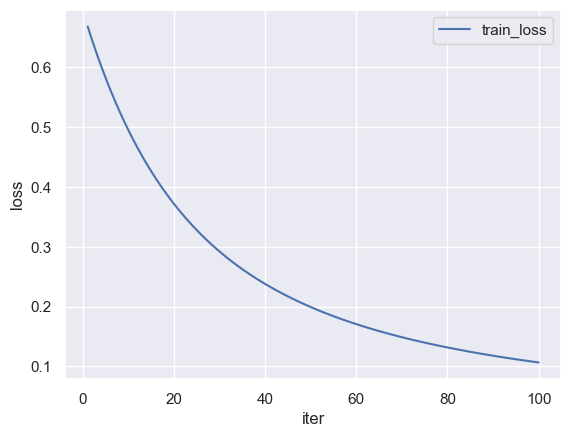

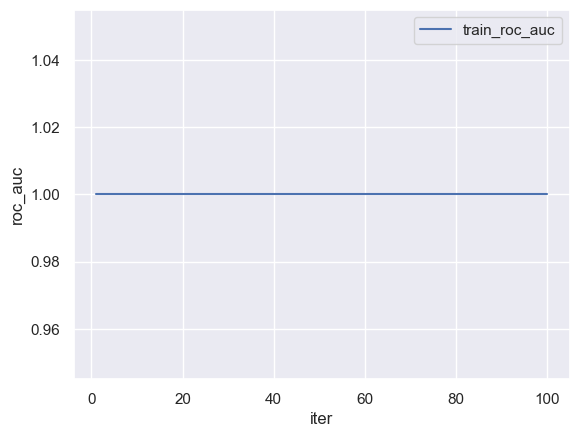

Train ROC-AUC 1.0000
Valid ROC-AUC 0.8338
Test ROC-AUC 0.8589


In [18]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Задание 2. Имплементация гиперпараметров

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации безотносительно базовой модели. В этом пункте предлагается имплементировать часть из них. При необходимости можете обратиться к реализациям в вашей любимой библиотеке, там могут быть дополнительные пояснения и/или ссылки на оригинальные статьи

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотрить именно на них

### 2.1. Борьба с переобучением

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете делать для трейна, нужно будет повторить на валидации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| <td colspan=3>`early_stopping_rounds`, `eval_set` |

Добавьте параметры:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `X_val`, `y_val` или `eval_set: Tuple[np.ndarray] | None = None` — валидацонная выборка, на которой будем проверять переобучение

In [ ]:
def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 0
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators
        self.learning_rate: float = learning_rate
        self.early_stopping_rounds: int | None = early_stopping_rounds

        self.models: list = []
        self.gammas: list = []
        self.best_val_loss = float('inf')

        self.history = defaultdict(list)  # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _predict_scores(self, X) -> np.ndarray:
        z = np.zeros(X.shape[0])
        for m, g in zip(self.models, self.gammas):
            z += self.learning_rate * g * m.predict(X)
        return z

    def partial_fit(self, X, y):
        old_predictions = self._predict_scores(X)

        residual = -self.loss_derivative(y, old_predictions)

        model = self.base_model_class(**self.base_model_params)
        model.fit(X, residual)

        new_predictions = model.predict(X)

        gamma = self.find_optimal_gamma(y, old_predictions, new_predictions)

        self.models.append(model)
        self.gammas.append(gamma)

        return self

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        cnt = 0

        for _ in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_scores = self._predict_scores(X_train)
            self.history["train_loss"].append(float(self.loss_fn(y_train, train_scores)))
            self.history["train_roc_auc"].append(float(score(self, X_train, y_train)))

            if X_val is not None and y_val is not None:
                val_scores = self._predict_scores(X_val)
                self.history["val_loss"].append(float(self.loss_fn(y_val, val_scores)))
                self.history["val_roc_auc"].append(float(score(self, X_val, y_val)))
                if self.history["val_loss"][-1] < self.best_val_loss:
                    self.best_val_loss = self.history["val_loss"][-1]
                    cnt = 0
                else:
                    cnt += 1
                if self.early_stopping_rounds not in (None, 0) and cnt >= self.early_stopping_rounds:
                    break

        if plot:
            self.plot_history(X_train, y_train)

        return self

    def predict_proba(self, X):
        z = self._predict_scores(X)
        p_pos = self.sigmoid(z)
        p_neg = 1.0 - p_pos
        return np.column_stack([p_neg, p_pos])

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return float(gammas[int(np.argmin(losses))])

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self, X, y):
        iters = np.arange(1, len(self.history["train_loss"]) + 1)

        plt.figure()
        plt.plot(iters, self.history["train_loss"], label="train_loss")
        if "val_loss" in self.history and len(self.history["val_loss"]) > 0:
            plt.plot(iters, self.history["val_loss"], label="val_loss")
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(iters, self.history["train_roc_auc"], label="train_roc_auc")
        if "val_roc_auc" in self.history and len(self.history["val_roc_auc"]) > 0:
            plt.plot(iters, self.history["val_roc_auc"], label="val_roc_auc")
        plt.xlabel("iter")
        plt.ylabel("roc_auc")
        plt.legend()
        plt.show()

### 2.2. Бутстрап
Как известно, при обучении базовых алгоритмов в беггинге используется бутстрапированная выборка. Почему бы не попробовать сделать то же самое в бустинге?

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `subsample`, — | `subsample`, `bagging`| `subsample`, `bootstrap_type`|

Вам нужно реализовать параметры:
- `subsample: float | int = 1.0` — доля или число объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float | int = 1.0` — веса объектов, которые попадают в выборку. Соответствует бутстрапу типа `Bayesian`. Каждый объект имеет определенный вес $t$, на который впоследствии домножается по формуле $w = (-\log(X))^t$, где $X \sim {U[0, 1]}$, после чего попадает в выборку. Таким образом можно сделать симуляцию повторений
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<font color='plum'>**Вопрос на подумать:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

In [ ]:
import numpy as np
from collections import defaultdict
from typing import Optional
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 0,
        subsample: float | int = 1.0,
        bagging_temperature: float | int = 1.0,
        bootstrap_type: str | None = "Bernoulli",
        random_state: int = 42,
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators
        self.learning_rate: float = learning_rate
        self.early_stopping_rounds: int | None = early_stopping_rounds

        self.subsample = subsample  # <- исправил опечатку
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type

        self.models: list = []
        self.gammas: list = []
        self.best_val_loss = float("inf")

        self.history = defaultdict(list)

        self._rng = np.random.default_rng(random_state)

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _predict_scores(self, X) -> np.ndarray:
        z = np.zeros(X.shape[0])
        for m, g in zip(self.models, self.gammas):
            z += self.learning_rate * g * m.predict(X)
        return z

    # --- БУТСТРАП --- #
    def _make_bootstrap(self, X, y):
        """
        Возвращает (Xb, yb, sample_weight)
        sample_weight=None, если веса не нужны.
        """
        n = X.shape[0]
        bt = self.bootstrap_type

        # Нет бутстрапа: весь датасет
        if bt is None:
            return X, y, None

        bt = str(bt).lower()

        # --- Bernoulli bootstrap ---
        # subsample: float -> доля; int -> число объектов
        if bt == "bernoulli":
            if isinstance(self.subsample, float):
                p = float(self.subsample)
                if not (0.0 < p <= 1.0):
                    raise ValueError("subsample(float) должен быть в (0, 1].")
                mask = self._rng.random(n) < p  # независимое включение объектов
                if not np.any(mask):  # чтобы не получить пустую выборку
                    mask[self._rng.integers(0, n)] = True
                return X[mask], y[mask], None

            # int: берём ровно k объектов (без повторений)
            k = int(self.subsample)
            if not (1 <= k <= n):
                raise ValueError("subsample(int) должен быть в [1, n].")
            idx = self._rng.choice(n, size=k, replace=False)
            return X[idx], y[idx], None

        # --- Bayesian bootstrap ---
        # веса: w = (-log(U))^t, U~U(0,1)
        if bt == "bayesian":
            u = self._rng.random(n)
            w = (-np.log(u)) ** float(self.bagging_temperature)

            # если задан subsample<1 (float), то часть весов зануляем (как в CatBoost-логике)
            if isinstance(self.subsample, float) and float(self.subsample) < 1.0:
                p = float(self.subsample)
                mask = self._rng.random(n) < p
                w = w * mask.astype(float)
                if np.all(w == 0):
                    w[self._rng.integers(0, n)] = 1.0

            # можно обучать на всех объектах, передав sample_weight
            return X, y, w

        raise ValueError("bootstrap_type должен быть None / 'Bernoulli' / 'Bayesian'.")

    def partial_fit(self, X, y):
        # текущие скоры ансамбля на ВСЕХ train-объектах (для вычисления антиградиента)
        old_predictions = self._predict_scores(X)

        # антиградиент по z (на нём учим дерево)
        residual = -self.loss_derivative(y, old_predictions)

        # бутстрапируем (X, residual) и при необходимости веса
        Xb, rb, sample_weight = self._make_bootstrap(X, residual)

        # учим базовую модель на подвыборке / с весами
        model = self.base_model_class(**self.base_model_params)
        if sample_weight is None:
            model.fit(Xb, rb)
        else:
            model.fit(Xb, rb, sample_weight=sample_weight)

        # предсказания нового дерева на ВСЕХ X (нужно для подбора gamma)
        new_predictions = model.predict(X)
        gamma = self.find_optimal_gamma(y, old_predictions, new_predictions)

        self.models.append(model)
        self.gammas.append(gamma)
        return self

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        cnt = 0

        for _ in range(self.n_estimators):
            self.partial_fit(X_train, y_train)

            train_scores = self._predict_scores(X_train)
            self.history["train_loss"].append(float(self.loss_fn(y_train, train_scores)))
            self.history["train_roc_auc"].append(float(score(self, X_train, y_train)))

            if X_val is not None and y_val is not None:
                val_scores = self._predict_scores(X_val)
                self.history["val_loss"].append(float(self.loss_fn(y_val, val_scores)))
                self.history["val_roc_auc"].append(float(score(self, X_val, y_val)))

                if self.history["val_loss"][-1] < self.best_val_loss:
                    self.best_val_loss = self.history["val_loss"][-1]
                    cnt = 0
                else:
                    cnt += 1

                if self.early_stopping_rounds not in (None, 0) and cnt >= self.early_stopping_rounds:
                    break

        if plot:
            self.plot_history(X_train, y_train)

        return self

    def predict_proba(self, X):
        z = self._predict_scores(X)
        p_pos = self.sigmoid(z)
        p_neg = 1.0 - p_pos
        return np.column_stack([p_neg, p_pos])

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return float(gammas[int(np.argmin(losses))])

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self, X, y):
        iters = np.arange(1, len(self.history["train_loss"]) + 1)

        plt.figure()
        plt.plot(iters, self.history["train_loss"], label="train_loss")
        if "val_loss" in self.history and len(self.history["val_loss"]) > 0:
            plt.plot(iters, self.history["val_loss"], label="val_loss")
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(iters, self.history["train_roc_auc"], label="train_roc_auc")
        if "val_roc_auc" in self.history and len(self.history["val_roc_auc"]) > 0:
            plt.plot(iters, self.history["val_roc_auc"], label="val_roc_auc")
        plt.xlabel("iter")
        plt.ylabel("roc_auc")
        plt.legend()
        plt.show()

### 2.3. GOSS

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов это исправить — ввести какие-то веса на объекты, однако можно пойти чуть хитрее. В <font color='lightgreen'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

Давайте оценивать важность объектов в отдельный момент обучения нового дерева. Будем считать, какой антиградиент привносит каждый объект. Далее разобъем градиенты на 2 группы. Объекты с большими градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом, с отрицательными — выкидываются. И не забываем домножить на фактор, чтобы учесть выкинутые объекты.

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | `bagging='goss'`| `bootstrap_type='MVS'`|

Параметры, которые нужно сделать:

- `goss: bool | None = False` — GOSS бустинг или нет
- `goss_k: float | int = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float | int = 0.3` — параметры сэмплинга для маленьких градиентов из пункта 2.1

In [ ]:
class Boosting:
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 0,

        subsample: float | int = 1.0,
        bagging_temperature: float | int = 1.0,
        bootstrap_type: str | None = "Bernoulli",

        # --- GOSS ---
        goss: bool | None = False,
        goss_k: float | int = 0.2,   # доля/число "больших" градиентов
        random_state: int = 42,
    ):
        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type

        self.goss = goss
        self.goss_k = goss_k

        self._rng = np.random.default_rng(random_state)

    def _make_goss_sample(self, X, y, residual):
        """
        Возвращает (Xg, rg, sample_weight)
        GOSS: берём все большие |residual| и часть малых, малым даём вес.
        """
        n = X.shape[0]

        # 1) сколько "больших"
        if isinstance(self.goss_k, float):
            k = int(np.floor(n * float(self.goss_k)))
        else:
            k = int(self.goss_k)
        k = max(1, min(k, n))  # защита

        # 2) индексы больших по |grad|
        abs_g = np.abs(residual)
        # берём топ-k по модулю
        idx_sorted = np.argsort(-abs_g)
        idx_big = idx_sorted[:k]
        idx_small = idx_sorted[k:]

        # 3) из малых берём подвыборку (используем subsample как в Бернулли)
        m = idx_small.size
        if m == 0:
            # все оказались "большими"
            return X[idx_big], residual[idx_big], np.ones(idx_big.size)

        if isinstance(self.subsample, float):
            p = float(self.subsample)
            if not (0.0 < p <= 1.0):
                raise ValueError("subsample(float) должен быть в (0, 1].")
            take_mask = self._rng.random(m) < p
            if not np.any(take_mask):
                take_mask[self._rng.integers(0, m)] = True
            idx_small_take = idx_small[take_mask]
            a = take_mask.mean()  # фактическая доля взятых малых
        else:
            s = int(self.subsample)
            s = max(1, min(s, m))
            idx_small_take = self._rng.choice(idx_small, size=s, replace=False)
            a = s / m  # доля взятых малых

        # 4) собираем итоговый индекс
        idx = np.concatenate([idx_big, idx_small_take])

        # 5) веса: большим 1, малым множитель (1-a)/a
        # чтобы суммарный вклад "малых" был сопоставим
        w = np.ones(idx.shape[0], dtype=float)
        if idx_small_take.size > 0:
            # позиции малых в idx: последние idx_small_take.size элементов
            w[-idx_small_take.size:] = (1.0 - a) / a

        return X[idx], residual[idx], w

    def partial_fit(self, X, y):
        old_predictions = self._predict_scores(X)

        # антиградиент
        residual = -self.loss_derivative(y, old_predictions)

        # --- ВОТ ТУТ ВЫБОР: GOSS или твой прежний бутстрап/без него ---
        if self.goss:
            Xb, rb, sample_weight = self._make_goss_sample(X, y, residual)
        else:
            # как у тебя было: либо бутстрап, либо весь датасет
            Xb, rb, sample_weight = self._make_bootstrap(X, residual)  # если есть
            # либо просто:
            # Xb, rb, sample_weight = X, residual, None

        model = self.base_model_class(**self.base_model_params)
        if sample_weight is None:
            model.fit(Xb, rb)
        else:
            model.fit(Xb, rb, sample_weight=sample_weight)

        new_predictions = model.predict(X)
        gamma = self.find_optimal_gamma(y, old_predictions, new_predictions)

        self.models.append(model)
        self.gammas.append(gamma)
        return self

### 2.4. Работа с признаками

1. Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать `rsm`

2. С другой стороны, вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет. Для этого существует множество алгоритмов, мы предлагаем сделать два наиболее простых:

- $\text{Uniform}$. Значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- $\text{Quantile}$. Тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `colsample_bytree`, `tree_method` | `colsample_bytree`, `max_bin`| `rsm`, `quantize(...)`|

Нужно добавить параметры:
- `rsm: float | int = 1.0` — доля или число признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

<font color='plum'>**Вопрос на подумать**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='plum'>**Вопрос на подумать**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)?</font>

### 2.5. Квантизация

В текущих имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, либо от того, что целевая переменная от бинов зависит опосредованно. Предлагается это исправить следующими способами:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='palegoldenrod'>**CatBoost**</font>, остальные на него очень похожи. Будем жадно набирать бины так, чтобы энтропия объектов внутри ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Сделать такое разбиение руками непросто, но вам эта задача должна что-то напоминать
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации будем брать не с потолка, а именно те, что нужны для разбиения таргета. (В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лмшь закодированную по формуле часть)

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | — | `feature_border_type="Piecewise"` |

Нужно добавить опцию:

- `'MinEntropy'` для `quantization_type` — какую квантизацию используем

Реализуйте оба способа подсчета (или один, но тогда балл неполный) и сравните, удалось ли улучшить качество?

### 2.5. DART

Ранее мы обсуждали, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="dart")` | `LGBMClassifier(boosting_type="dart")` | — |

Параметры, которые нужно добавить:

- `dart: bool | None = False` — DART бустинг или нет
- `dropout_rate: int | float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

In [ ]:
# TODO

------

## Задание 3. Оптимизация

Теперь давайте подумаем, как же правильно применять бустинги. Нас интересует: какие бустинги вообще бывают, как их правильно тюнить, и как интерпретировать

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. У бустингов, хотя на самом деле не только, эта проблема стоит особенно остро. Подумаем, как это делать умнее

### 3.1. Знакомство с optuna

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`
- любые другие параметры, которые вам понравились

Заметим, что оптуна это крайне гибкая библиотека, в которой можно реализовать абсолютно любую логику, которую пожелаете. За вас там есть лишь выбор модели. Чтобы не плодить несколько `objective`, можно слегка менять тело функции, например, добавить опциональные параметры, но шаблоном пользоваться не обязательно, как обычно

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Сравните графики функций потерь для оптимального и дефолтного бустингов. Покажите, какие параметры дали наибольший прирост (для этого придется почитать документацию оптуны)

### 3.2. Глубокая оптимизация

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения. Улучшите процедуру оптимизации следующим образом:

1. Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин
2. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из `optuna.pruners`. Идея прунера — не обучать бустинг до конца, если по истории видно, что другие бустинги на этом этапе статистически лучше.
3. Добавьте сохранение истории функции потерь и времени обучения в качестве `user_attribute` сразу в `study`. Мы не хотим оптимизировать их напрямую, но они нам понадобится для сравнения моделей в дальнейшем

Добавьте хранилище и юзер атрибуты и посмотрите, ускорилась ли оптимизация с добавлением прунера

### 3.3. Готовые реализации

Библиотек для бустингов существует много, но активно используются лишь три. Ваша задача — попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='lightblue'>`xgboost`</font>, <font color='lightgreen'>`lightgbm`</font>, <font color='palegoldenrod'>`catboost`</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, плюс что-то, что вам понравилось в них больше всего (может быть абсолютно любая фишка из пунктов выше или что-то, что вы найдете сами, не обязательно эксклюзивное), и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения

In [ ]:
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.sparse import vstack as sp_vstack 
from lightgbm import LGBMClassifier

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

def to01(y):
    y = np.asarray(y).ravel()
    vals = set(np.unique(y))
    if vals == {-1, 1}:
        return (y == 1).astype(int)
    return y.astype(int)

y_train = to01(y_train)
y_valid = to01(y_valid)
y_test  = to01(y_test)

def obj_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 100.0, log=True),

        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 1337,
        "n_jobs": -1,
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    probas = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, probas)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(obj_xgb, n_trials=5)

best_params_xgb = study_xgb.best_params

best_model = XGBClassifier(
    **best_params_xgb,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=1337,
    n_jobs=-1,
)

# ВАЖНО: если X_* = csr_matrix, то используем scipy.sparse.vstack
X_trval = sp_vstack([X_train, X_valid])
y_trval = np.concatenate([y_train, y_valid])

best_model.fit(X_trval, y_trval)

xgb_test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("XGB valid best_auc:", study_xgb.best_value)
print("XGB test_auc:", xgb_test_auc)
print("XGB best_params:", best_params_xgb)

# 3) LIGHTGBM
def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 100.0, log=True),
        "objective": "binary",
        "metric": "auc",
        "random_state": 1337,
        "n_jobs": -1,
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="auc",
        callbacks=[],  # без ранней остановки, чтобы не упираться в версию/callbacks
    )
    proba = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, proba)

study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=5)

best_lgb_params = study_lgb.best_params

lgb_best = LGBMClassifier(
    **best_lgb_params,
    objective="binary",
    random_state=1337,
    n_jobs=-1,
)

X_trval = sp_vstack([X_train, X_valid]) if issparse(X_train) else np.vstack([X_train, X_valid])
y_trval = np.concatenate([y_train, y_valid])

lgb_best.fit(X_trval, y_trval)

lgb_test_auc = roc_auc_score(y_test, lgb_best.predict_proba(X_test)[:, 1])

print("LGB valid best_auc:", study_lgb.best_value)
print("LGB test_auc:", lgb_test_auc)
print("LGB best_params:", best_lgb_params)


[I 2026-02-05 16:37:47,843] A new study created in memory with name: no-name-e1efed77-a937-4efa-816c-a2de145b441a
[I 2026-02-05 16:37:49,455] Trial 0 finished with value: 0.9503679008936144 and parameters: {'n_estimators': 1541, 'learning_rate': 0.03884899375905505, 'max_depth': 4, 'min_child_weight': 4.616132959152477, 'gamma': 6.970664773830806, 'reg_lambda': 24.969382525977316, 'reg_alpha': 22.258373139627142}. Best is trial 0 with value: 0.9503679008936144.
[I 2026-02-05 16:37:50,583] Trial 1 finished with value: 0.9465803957153847 and parameters: {'n_estimators': 353, 'learning_rate': 0.011367909797153776, 'max_depth': 4, 'min_child_weight': 17.2998280375642, 'gamma': 1.0187385072843835, 'reg_lambda': 25.275146772883208, 'reg_alpha': 0.0050336056002001275}. Best is trial 0 with value: 0.9503679008936144.
[I 2026-02-05 16:37:52,448] Trial 2 finished with value: 0.9166748860789459 and parameters: {'n_estimators': 1354, 'learning_rate': 0.003796223545195439, 'max_depth': 2, 'min_chil

XGB valid best_auc: 0.9730995074928163
XGB test_auc: 0.9823331788693235
XGB best_params: {'n_estimators': 984, 'learning_rate': 0.030373640006451548, 'max_depth': 6, 'min_child_weight': 3.357072234806136, 'gamma': 3.1170897287976294, 'reg_lambda': 29.185283546965117, 'reg_alpha': 0.0026405415037356545}
[LightGBM] [Info] Number of positive: 2579, number of negative: 3821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38798
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402969 -> initscore=-0.393110
[LightGBM] [Info] Start training from score -0.393110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2026-02-05 16:38:07,861] Trial 0 finished with value: 0.9427139841792752 and parameters: {'n_estimators': 4209, 'learning_rate': 0.0011670827121146637, 'num_leaves': 242, 'max_depth': 7, 'min_child_samples': 123, 'subsample': 0.7700697485032693, 'colsample_bytree': 0.6227538073949723, 'reg_lambda': 0.0021553716021613825, 'reg_alpha': 56.20654144865989}. Best is trial 0 with value: 0.9427139841792752.


[LightGBM] [Info] Number of positive: 2579, number of negative: 3821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38798
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402969 -> initscore=-0.393110
[LightGBM] [Info] Start training from score -0.393110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2026-02-05 16:38:09,734] Trial 1 finished with value: 0.9353493907771618 and parameters: {'n_estimators': 3187, 'learning_rate': 0.0727605382061653, 'num_leaves': 225, 'max_depth': 1, 'min_child_samples': 101, 'subsample': 0.5886813052720801, 'colsample_bytree': 0.7284692301317666, 'reg_lambda': 0.34681646609963923, 'reg_alpha': 3.030930927978688}. Best is trial 0 with value: 0.9427139841792752.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-05 16:38:14,137] Trial 2 finished with value: 0.9564371149205347 and parameters: {'n_estimators': 1731, 'learning_rate': 0.002275244178481154, 'num_leaves': 200, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.752347286972231, 'colsample_bytree': 0.6643109170415553, 'reg_lambda': 0.06257332936948018, 'reg_alpha': 0.08868467807484594}. Best is trial 2 with value: 0.9564371149205347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-05 16:38:19,409] Trial 3 finished with value: 0.977472234825321 and parameters: {'n_estimators': 2411, 'learning_rate': 0.01571768436154342, 'num_leaves': 34, 'max_depth': 5, 'min_child_samples': 182, 'subsample': 0.8552402285675764, 'colsample_bytree': 0.56144210988582, 'reg_lambda': 2.4554282516783363, 'reg_alpha': 0.0015030752052093235}. Best is trial 3 with value: 0.977472234825321.


[LightGBM] [Info] Number of positive: 2579, number of negative: 3821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38798
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402969 -> initscore=-0.393110
[LightGBM] [Info] Start training from score -0.393110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2026-02-05 16:38:47,955] Trial 4 finished with value: 0.9769856456183957 and parameters: {'n_estimators': 2412, 'learning_rate': 0.03335183532303639, 'num_leaves': 73, 'max_depth': 0, 'min_child_samples': 23, 'subsample': 0.7558859819345785, 'colsample_bytree': 0.6179234949803589, 'reg_lambda': 96.2162824114158, 'reg_alpha': 0.7401976951539848}. Best is trial 3 with value: 0.977472234825321.


[LightGBM] [Info] Number of positive: 2890, number of negative: 4310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42356
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.401389 -> initscore=-0.399681
[LightGBM] [Info] Start training from score -0.399681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain